## 3. Signal processing / System identification

#### Signal processing (Consider two analyses in different frequency bands)
- Filter and Decimation (IIR Filter)
    - $M = $ Number of IIR filter coefficients ("order")
    - $f_c =$ Filter 3 dB cutoff frequency
    - $d = $ Decimation rate (every d-th sample)
- $\hat{\Phi}(\omega)$ Spectral estimator (Welch, Blackman-Tukey)
    - Time / Lag Window (If PSDs are involved)  <br>**TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $ 2 (n_\mathrm{lags} - 1) = n_\mathrm{lines}$ Number of time lags ↔ number of frequency lines ($\tau_\mathrm{max} = n_\mathrm{lags} \Delta t$ Correlation length ↔ Frequency Resolution $\Delta f = \frac{f_s}{n_\mathrm{lines}}$)
- use non-reference based OMA ($n_\mathrm{ref}$ Number and $\operatorname{loc}_\mathrm{ref}$ location of reference channels) 

#### Systemidentification
- $n_\mathrm{ord}^\mathrm{max} = $ max model order
- Identification Algorithm (SSI-cov, SSI-data, pLSCF) -> Three case studies, pLSCF might need some work in terms of verification, efficiency, etc.

#### Outputs
- PSD Energy
- **TODO: Cross-validated reconstruction error of the identified system**

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
sys.path.append("/home/sima9999/git/pyOMA/")
from pathlib import Path


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from examples.UQ_OMA import vars_definition

import ray

from uncertainty.polymorphic_uncertainty import PolyUQ
from uncertainty.data_manager import DataManager

from model.acquisition import Acquire, sensor_position

import pyOMA

from pyOMA.core.PreProcessingTools import PreProcessSignals, GeometryProcessor, SignalPlot
from pyOMA.core.SSICovRef import BRSSICovRef

import logging


%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas

## Parameters

In [3]:
result_dir = Path('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

### Uncertainty Propagation

In [2]:
vars_ale, vars_epi, arg_vars = vars_definition(stage=3)
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 1000
N_mcs_epi = 1000
use_dm = True


In [3]:
# poly_uq2 = poly_uq

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    
    poly_uq_stage1 = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq_stage1.load_state(os.path.join(result_dir,'polyuq_samp_stage1.npz'), differential='samp')
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=poly_uq_stage1.seed)
    display(poly_uq.var_supp)
    
    '''
    Apparently there were some bugs in QMC, that were fixed in 1.11 and changed the way Halton
    Sequences are scrambled. Therefore reproducibility is broken, and existing samples must be
    copied to the new sequences manually
    affects first variable (reverting fixes it):
    https://github.com/scipy/scipy/commit/75371c5cb8a10f4a4172f8670f0ee53546b61796
    affects all further variables:
    https://github.com/scipy/scipy/commit/4c5d0e39a24ed39e0d242194b11671a45c55d067
    
    '''
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        poly_uq.inp_samp_prim[var_name] = poly_uq_stage1.inp_samp_prim[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        poly_uq.inp_suppl_ale[var_name] = poly_uq_stage1.inp_suppl_ale[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        poly_uq.inp_suppl_epi[var_name] = poly_uq_stage1.inp_suppl_epi[var_name]
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    # check, that samples are indeed the same
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_samp_prim[var_name][:], poly_uq.inp_samp_prim[var_name][:])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_ale[var_name], poly_uq.inp_suppl_ale[var_name])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_epi[var_name], poly_uq.inp_suppl_epi[var_name])
        plt.title(var_name)
    
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    

if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')
    plt.gcf().set_size_inches((18,18))

if False:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None


INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/polyuq_samp.npz


In [6]:
dm_grid = None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')

todo = False    


while todo:    
    todo = dm_grid.evaluate_samples(stage3mapping, arg_vars, 
                         ret_names={'bits_effective':(), 'snr_db_est':(), 
                                    'snr_db':()}, default_len={'node':203, 'dir':2}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=True,
                         chunks_submit=10000, chunks_save=500, scramble_evaluation=False,
                                   remote_kwargs={'num_cpus':1, 'memory':4300 * 1024 * 1024})


In [ ]:
ray.shutdown()

### Signal Processing


In [353]:
jid = '0e8132ee_0e9f1c84'
seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

    
# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / 'samples' / id_ale
    this_result_dir = this_result_dir / id_epi

acqui_c = Acquire.load(this_result_dir / 'measurement.npz', differential='sampled')


INFO:model.acquisition:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/0e8132ee/0e9f1c84/measurement.npz


In [354]:
pd_kwargs = acqui_c.to_prep_data()
ref_channels=np.where(acqui_c.channel_defs[:,0]==201)[0]
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)

INFO:model.acquisition:Using a sampled signal


#### decimation

In [355]:
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs)
print(prep_signals.sampling_rate)
M = 4
fc = 5
d = 2
# prep_signals.decimate_signals(d, nyq_rat = prep_signals.sampling_rate / fc, order=M)


70.0


In [356]:

n_lags = 200
prep_signals.correlation(n_lags, 'blackman-tukey')
pass

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=200 and num_blocks=1...
....................................................................................................


#### Display Signals

INFO:pyOMA.core.PreProcessingTools:Estimating Power Spectral Density by Blackman-Tukey's method...
....................................................................................................


(array([<AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>],
       dtype=object),
 array([<AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
     

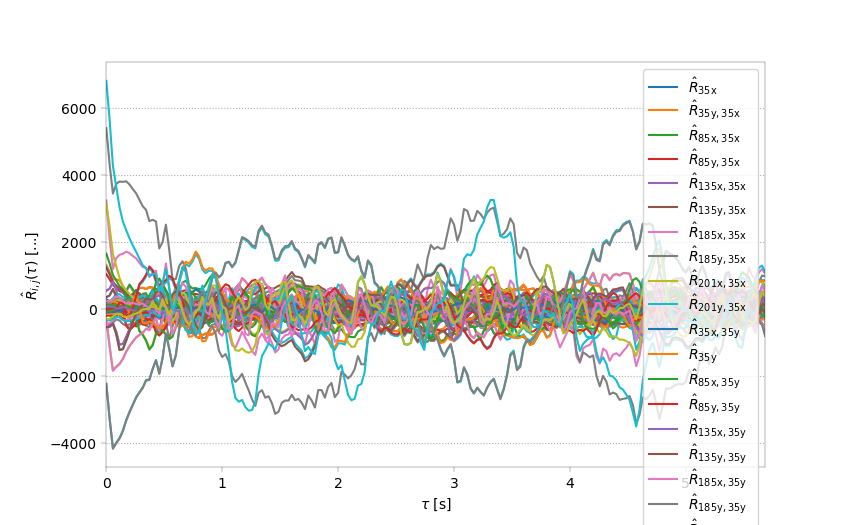

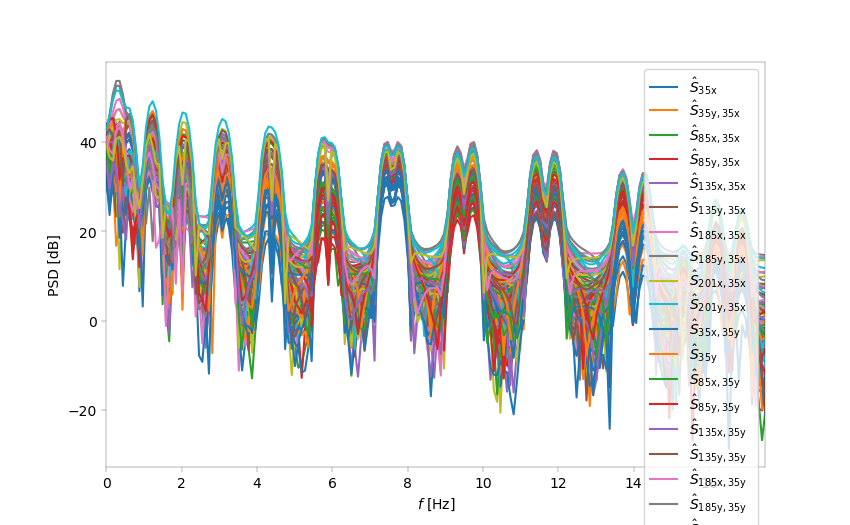

In [260]:
pyOMA.core.PreProcessingTools.SignalPlot(prep_signals).plot_signals(timescale='lags', psd_scale='db')

### System Identification

In [357]:
modal_data = BRSSICovRef(prep_signals)

In [358]:
n_ord_max = 100
order = 50
modal_data.build_toeplitz_cov(prep_signals.n_lags // 2)
modal_data.compute_state_matrices(n_ord_max)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, this_modal_contributions = \
                modal_data.single_order_modal(order, plot_=False, corr_synth=False)

Assembling toeplitz matrix using pre-computed correlation functions 100 block-columns and 101 block rows
Computing state matrices with pinv-based method, with maximum model order 100...


#### Modal analysis (manual)

In [263]:
modal_data.compute_modal_params()

Computing modal parameters...
....................................................................................................


In [264]:
from pyOMA.core.StabilDiagram import StabilCalc, StabilPlot
from pyOMA.core.PlotMSH import ModeShapePlot

from pyOMA.GUI.JupyterGUI import PlotMSHWeb, StabilGUIWeb, SnappingCursor, OutputWidgetHandler, ConfigGUIWeb

In [265]:
stabil_calc = StabilCalc(modal_data, prep_signals)
stabil_plot = StabilPlot(stabil_calc)

display(StabilGUIWeb(stabil_plot))

Checking stabilisation criteria...
....................................................................................................


#### Mode shape visualization (numerical, identified, manually identified)

In [359]:
from pyOMA.core.PostProcessingTools import MergePoSER

channel_defs = acqui_c.channel_defs, 
channel_headers = pd_kwargs['channel_headers']
coordinates = np.copy(channel_defs[0])
coordinates[:,1:3] = 0
coordinates = np.roll(coordinates, -1, axis=1)
nodes = {str(coordinates[i*2,2]):list(coordinates[i*2,:]) for i in range(len(channel_headers)//2)}
lines = [([coordinates[i*2,2], coordinates[i*2+2, 2]]) for i in range(len(channel_headers)//2 - 1)]
chan_dofs = []
for i in range(len(channel_defs[0])):
    channel_name = channel_headers[i]
    node = str(coordinates[i,2])
    az, elev = [(0, 0), (270, 0), (90, 0)][channel_defs[0][i,1]]
    chan_dofs.append([i, node, az, elev, channel_name])
geometry = GeometryProcessor(nodes, lines)
prep_signals.chan_dofs = []
prep_signals.add_chan_dofs(chan_dofs)

##### Manual

In [267]:
mode_shape_plot = ModeShapePlot(amplitude=10,
                                prep_data=prep_signals,
                                stabil_calc=stabil_calc,
                                geometry_data=geometry,
                                modal_data=modal_data)

##### Numerical

In [363]:
merged_data = MergePoSER()

merged_data.mean_damping = acqui_c.modal_damping_samp[:,np.newaxis]
merged_data.mean_frequencies = acqui_c.modal_frequencies_samp[:,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = acqui_c.mode_shapes_samp[:,np.newaxis,:]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [364]:
mode_shape_plot = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )

##### Identified

In [360]:
merged_data = MergePoSER()

merged_data.mean_frequencies = this_modal_frequencies[:,np.newaxis]
merged_data.mean_damping = this_modal_damping[:,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = this_mode_shapes[:,np.newaxis,:]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [361]:
mode_shape_plot = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )

### Display

In [365]:
display(PlotMSHWeb(mode_shape_plot))

## Continue

Further test mapping parameters noise etc for any unwanted/unrealistic effects on the identification
check modeshape rotation with a different example (where alpha is odd)

then just choose a different example and see, if problem keeps appearing
